---
# What is the effect of increasing the number of data points on classification results?
---

In this example, we generate a dataset from a mixture of two gaussian probability distribution functions (PDF). 
Each one is weighted with its <i>a priori</i> class probability $P(C_{i})$:

<blockquote>  $P(\bf{x}) = P(\bf{x}|C_{1}) P(C_{1}) + P(\bf{x}|C_{2}) P(C_{2})$ </blockquote>


Using this "experimental dataset" and the quadratic discriminant analysis method (QDA), we can observe 
the influence zone of each class i over a spatial grid. This corresponds to the zone where 

<blockquote> $P(\bf{x}|C_{i}) P(C_{i}) > P(\bf{x}|C_{j}) P(C_{j})$ </blockquote>

We investigate the effect of increasing the size of the experimental dataset on the accuracy of the classifications. 
The number of data points varies from 100 to 100K. This example shows the danger of drawing conclusions on very small datasets.


In [1]:
print(__doc__)

# Authors: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: XXX

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import multivariate_normal

from skimage.transform import resize

import math

import seaborn as sns; sns.set()
np.random.seed(42)

Automatically created module for IPython interactive environment


# Function used to show the classification results.
The underlying PDF (in 2D and 3D) is the TRUE one, not an approximation based on the "experimental dataset". There may be some 
slight mismatches between the overlying and underlying boundaries due to differences in resolution.

In [2]:
def generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset=-0.1, view=[15, -20]):
    
    #---------- Generate the TRUE gaussian probability data distributions (PDF) ----------
    
    # Compute the covariance matrix Sigma for each gaussian PDF
    n_PDF = 2
    Sigma = np.zeros((2, 2, n_PDF))
    for n in range(n_PDF):
        cov = np.zeros((2, 2))

        # Rotation matrix
        angle = np.radians(theta[n])
        c, s = np.cos(angle), np.sin(angle)
        R = np.array([[c, -s], [s, c]])

        # Covariance matrix for a PDF with its principal axes oriented along the x and y directions
        C = np.array([[sigma[n,0]**2, 0.],[0., sigma[n,1]**2]])

        # Covariance matrix after rotation
        Sigma[:,:,n] = R.dot(C.dot(R.T))


    # Generate a spatial grid where the PDF will be evaluated locally.
    nx, ny = 300, 300
    xx, yy = np.meshgrid(np.linspace(0., 10., nx), np.linspace(0., 10., ny))
    pos = np.dstack((xx, yy)) 
    

    # Compute the global PDF as a sum of weighted PDF
    pdf = 0
    for n in range(n_PDF):
        model = multivariate_normal(Mu[n,:], Sigma[:,:,n]) 
        pdf +=prob_C[n]*model.pdf(pos)

        
    #------------- Generate datasets based on the estimated parameters of the TRUE distributions --------
    
    # Number of data points allocated to each PDF 
    n = (npts*prob_C).astype(int)

    X0 = np.random.multivariate_normal(Mu[0], Sigma[:,:,0], n[0])        
    X1 = np.random.multivariate_normal(Mu[1], Sigma[:,:,1], n[1])
    X = np.r_[X0, X1]
    y = np.hstack((np.zeros(n[0]), np.ones(n[1])))
    
    # Evaluate the gaussian PDF parameters based on the available data, i.e. the new dataset. 
    Mu_hat = np.zeros([2,2])
    Mu_hat[0,:] = np.mean(X0,axis=0)
    Mu_hat[1,:] = np.mean(X1,axis=0)

    Sigma_hat = np.zeros([2,2,2])
    Sigma_hat[:,:,0] = np.cov(X0.T)
    Sigma_hat[:,:,1] = np.cov(X1.T)

    pC_hat = prob_C

    
    # ------------- Classification ------------------------
    
    # Generate a classification at every point on the spatial grid based on the available data
    X = np.c_[xx.ravel(), yy.ravel()]
    h = np.zeros(X.shape)

    X = X.T
    Mu_hat = Mu_hat.T

    # Define the discriminant functions h for the gaussian PDF
    for i in range(n_PDF):
        mu = Mu_hat[:,i]

        S_inv = np.linalg.inv(Sigma_hat[:,:,i])
        det_S = np.linalg.det(Sigma_hat[:,:,i])

        w0 = -0.5*math.log(det_S) + math.log(pC_hat[i])

        ww = np.zeros((X.shape[1],1))
        for j in range(X.shape[1]):
            dX = (X[:,j] - mu).reshape(-1, 1)
            ww[j] = (dX.T).dot(S_inv.dot(dX))

        h[:,i] = (-0.5*ww + w0).ravel()


    # Find the winning class and its influence zone on the spatial grid. 
    C = h[:,1]>h[:,0]

    C = C.reshape(xx.shape)
    C = C.astype(float)

    mask = C

    # -------------- Display the results ------------------------
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca(projection='3d')

    # Generate OVERLYING 3-D surface with colors indicating the influence zone of each class
    rstride, cstride = 5, 5
    s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='w', edgecolors='k')       
    a1 = s.__dict__['_original_facecolor']
    b1 = s.__dict__['_facecolors']
    c1 = s.__dict__['_facecolors3d']

    s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='gray', edgecolors='k')
    a2 = s.__dict__['_original_facecolor']
    b2 = s.__dict__['_facecolors']
    c2 = s.__dict__['_facecolors3d']

    Lx = int(nx/rstride)
    Ly = int(ny/cstride)

    mask = resize(mask, (Lx,Ly), order=0)
    indx = np.argwhere(mask)
    idx = indx[:,0]*Lx + indx[:,1]

    a = a1
    b = b1
    c = c1
    for i in idx:
        a[i,:] = a2[i,:]
        b[i,:] = b2[i,:]
        c[i,:] = c2[i,:]
    s.__dict__['_original_facecolor'] = a
    s.__dict__['_facecolors'] = b
    s.__dict__['_facecolors3d'] = c    


    # Generate UNDERLYING filled contours with borders between each class
    cset = ax.contourf(xx, yy, pdf, zdir='z', offset=z_offset, cmap='viridis')

    # Display the boundary of the influence zone of each class
    ax.contour(xx, yy, C, [0.5], offset=z_offset, linewidths=2., colors='white') 

    ax.set_zlim(z_offset,np.max(pdf))

    ax.view_init(view[0], view[1])

    ax.set_ylabel('$x_{2}$', fontsize=18)
    ax.xaxis.set_rotate_label(False)  
    ax.set_xlabel('$x_{1}$', rotation=10, fontsize=18)
    ax.set_zlabel('$Z$', rotation=10, fontsize=18)
    ax.set_title('$Z = PDF(x_{1},x_{2})$', fontsize=18)

    fig.tight_layout()

    plt.savefig(figName, format="png")        

    plt.show()
    
    

## Baseline parameters of the two gaussians PDF used for generating the global PDF

In [3]:
# PDF origins
Mu = np.zeros((2,2))
Mu[0,:] = [4., 4.]
Mu[1,:] = [6., 6.]

# Standard deviations along principal axes
sigma = np.zeros((2,2))
sigma[0,:] = [1.5, .5]
sigma[1,:] = [0.5, 0.5]

# Rotation angle between principal axis and x axis 
theta = np.array([45., 0.]) 

# A priori probability of each class
prob_C = np.array([0.7, 0.3]) 

# Visualization parameters
z_offset = -0.15
view=[15.6, -19]


In the following cells, we only vary the number of data points used to estimate the parameters of both PDF. 
As the number of points increases, the parameter estimates converge towards their true values ($\widehat{P} \rightarrow P$) and the 
classification results no longer change.

## Case with 100 data points
For small datasets, the estimates of the parameter values and thus the classifications are innacurate. 

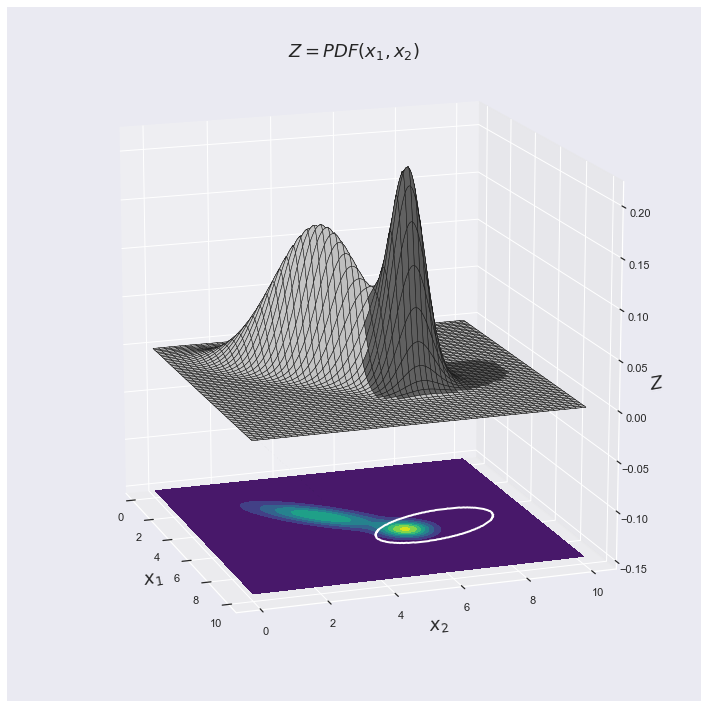

In [4]:
# For replicability
np.random.seed(42)

npts = 100
figName = "Classification_results_for_2_gaussian_PDF_generated_with_100_data_points.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view)

## Case with 1K data points
Some lateral symmetry emerges.

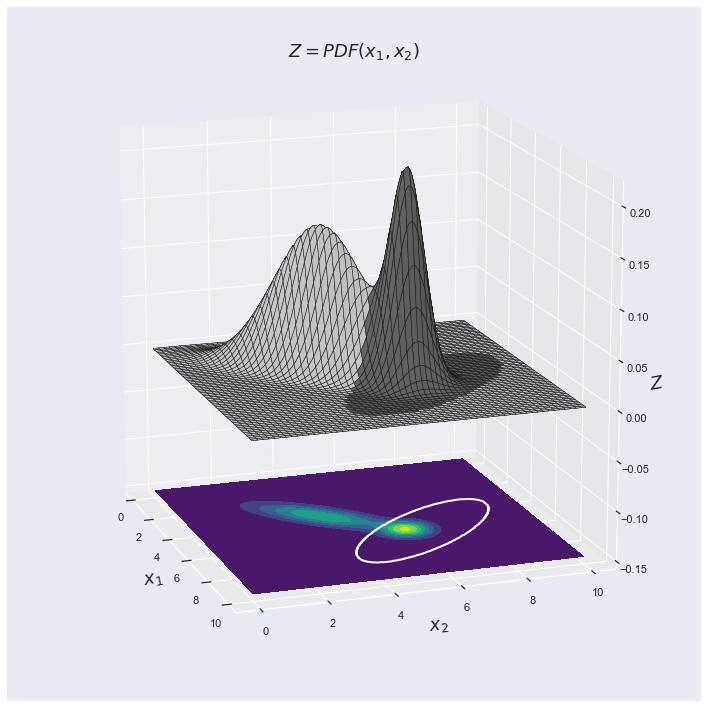

In [5]:
# For replicability
np.random.seed(42)

npts = 1000
figName = "Classification_results_for_2_gaussian_PDF_generated_with_1K_data_points.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view)

## Case with 10K data points
For the first time, an hyperbolic-looking frontier splits the grid in two.

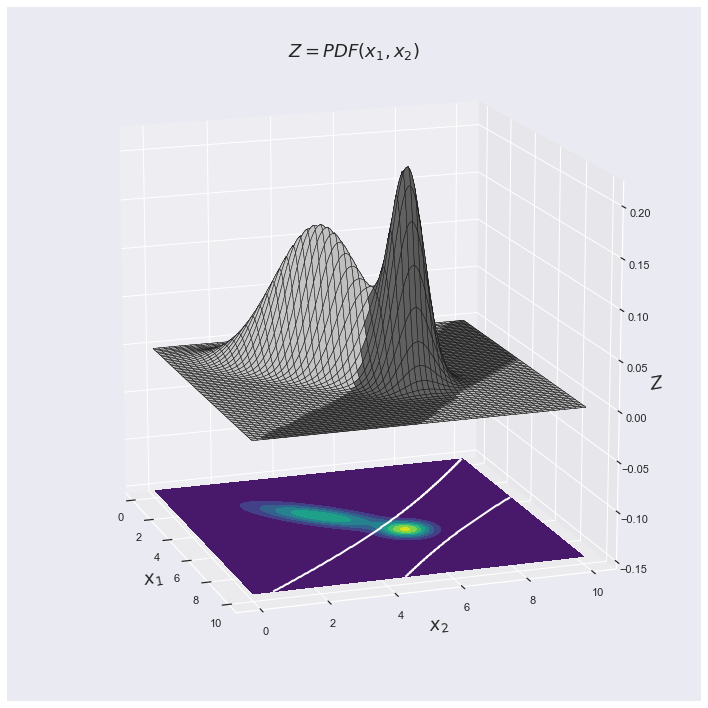

In [6]:
# For replicability
np.random.seed(42)

npts = 10000
figName = "Classification_results_for_2_gaussian_PDF_generated_with_10K_data_points.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view)

## Case with 100K data points
As the number of data points increases, we reach an asymptotic behaviour where the classification results no longer change. 
The parabolic borders become linear borders as predicted by theory.

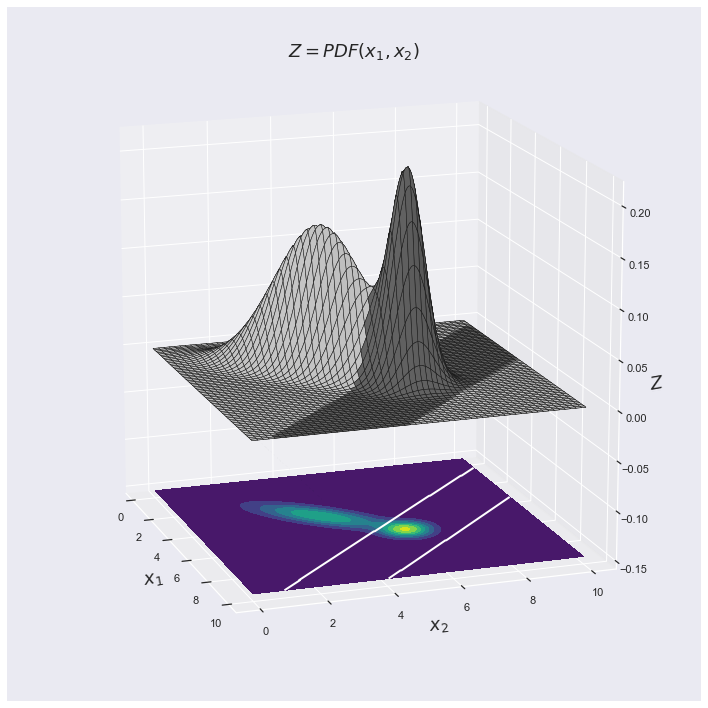

In [7]:
# For replicability
np.random.seed(42)

npts = 100000
figName = "Classification_results_for_2_gaussian_PDF_generated_with_100K_data_points.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view)